# Part 1: Mathematical morphology for binary images

Mathematical morphology is a branch of image processing that was developed in the 1960s by Georges Matheron and Jean Serra, two French researchers at the École des Mines de Paris. Relatively simple to understand from a conceptual point of view, this discipline makes it possible, with a little practice, to set up powerful non-linear filtering and shape detection/recognition algorithms.

Although it applies very well to grayscale images (see the session), and very poorly for color images, the mathematical morphology is understood first by manipulating binary images.

### Important

By convention, it is considered that everything that is in white in a binary image is an object, and the black corresponds to the background of the image.

### Imports and reading of data¶

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io
from ipywidgets import interact
import ipywidgets as widgets

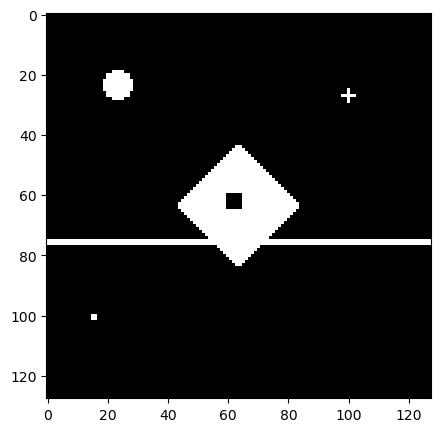

In [2]:
img = skimage.io.imread('images/mm/binaire.png').astype(bool)  # <- noter le type binaire utilisé !
plt.figure(figsize=(5,5))
plt.imshow(img,cmap='gray');

**How many objects are there in the previous image?**

TODO -- Write your answer here
<br>Human's answer: 5
<br>Computer's answer: 4 (It sees connected objects as one object.)

## 1. Erosion and dilation

The two basic operations of mathematical morphology are erosion and dilation. In both cases, they take as a parameter (in addition to the image to be processed) a structuring element (generally abbreviated SE or strel, for structuring element).

What is a structuring element?

- It's an image with a very simple shape: a square, a cross, a circle, a line, etc.
- Each structuring element depends on at least one parameter defining its size: the radius for a circle, the length for a line, etc.
- This structuring element is used to define a neighborhood mask around each pixel (you will understand the illustrations below).

In [3]:
# Let's define some shortcuts to a bunch of structuring element shapes
# There're all functions (width --> np.array)
from skimage.morphology import disk as se_disk, diamond as se_diamond, square as se_square
def se_cross(w):
    cross3 = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(bool)
    return skimage.transform.resize(cross3,(w,w))
def se_vert_l(l):
    return np.ones((l,1))
def se_horz_l(l):
    return np.ones((1,l))
def se_diag_l(l):
    return np.eye(l)

# A list with all our fonctions to generate structuring elements
MM_strel = [('disk', se_disk), ('diamond', se_diamond),('square', se_square), ('cross', se_cross),
            ('horz line', se_horz_l),('vert line', se_vert_l),('diag line', se_diag_l)]

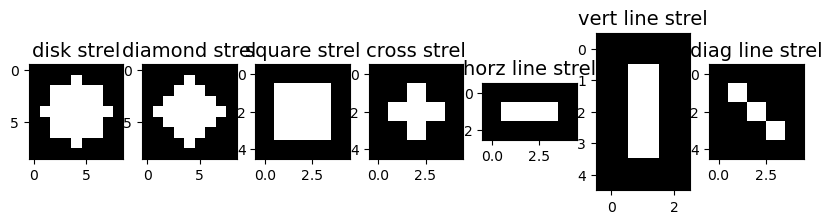

In [4]:
plt.figure(figsize=(10,5))
for ii, (name, se_function) in enumerate(MM_strel):
    plt.subplot(1,len(MM_strel),ii+1)
    strel = se_function(3)
    plt.imshow(np.pad(strel,1),cmap='gray')
    plt.title(f"{name} strel",fontsize=14)
plt.show()

### Erosion of a binary image by a given structuring element

Although there is a mathematical definition of erosion, there is no need to go into a somewhat cumbersome formalism to understand what happens: a drawing is better than a formula in this particular case. Let's look at the binary image below. 

<img src="figs/mm/Illustration_morpho.png" width=400>

Calculating the erosion of this binary image by a structuring element of a given form amounts, for each pixel, to ask the following question:

**Does the structuring element (centered on the current pixel) overflow the background of the image when I place it on the pixel - where I am?**

- If yes 

The pixel becomes white

- If not

The pixel stays black

For example, the result of the erosion of the previous image by a square-shaped structuring element $3 \times 3$
would look like this 

<img src="figs/mm/Illustration_erosion.png" width=400>



This time, the grey pixels correspond to the pixels of the background 'black' which are converted into pixels of the object 'white' following the expansion operation (therefore they would be 'white' in the dilated image).

The expansion operation causes the objects to swell with a shape defined by the structuring element.

More formally, the expansion affects the current pixel the maximum value of the neighborhood defined by the structuring element.

Mathematically, the erosion of an image $I$ by a structuring element $s$ is noted $\varepsilon(I,s)$, or $\varepsilon_s(I)$, or
$I \ominus s$.

For dilaration, use $\delta(I,s)$, $\delta_s(I)$, or $I \oplus s$

See [here](https://fr.wikipedia.org/wiki/Morphologie_math%C3%A9matique#Cas_ensembliste) ou [there](https://en.wikipedia.org/wiki/Mathematical_morphology#Binary_morphology) for the mathematical formulation of erosion and expansion operations.

In [5]:
# Let's define some shortcuts for erosion and dilation functions
from skimage.morphology import erosion
from skimage.morphology import dilation

MM_ope = [('erosion', erosion),('dilation', dilation)]

Good to know (or not): we tend, by habit, to import functions `skimage.morphology.erosion` and `skimage.morphology.dilation` of `scikit-image`, but these are actually the functions implemented in `scipy.ndimage` which work in the background.

**Using the interactive widget below, test the erosion and dilation operations on the previously charged binary image, varying the size and nature of the structuring element.**

In [6]:
@interact(op=widgets.RadioButtons(options=MM_ope,description='operation'),
         strel=widgets.Dropdown(options=MM_strel,description='strel'),
         param=widgets.IntSlider(value=3,min=3,max=15,step=1,description='size',continuous_update=False))
def basic_morpho(op,strel,param):
    strel_ = strel(param)
    strel_fig = np.zeros(np.array(strel_.shape)+2)
    strel_fig[1:-1,1:-1] = strel_
    img_op = op(img,strel_)
    plt.figure(figsize=(10,5))
    plt.subplot(131)
    plt.imshow(img,cmap='gray')
    plt.title('Binary image',fontsize=14)
    plt.subplot(132)
    plt.imshow(strel_fig,cmap='gray')
    plt.title('Structuring element (size %d)'%param,fontsize=14)
    plt.subplot(133)
    plt.imshow(img_op,cmap='gray')
    plt.title('Resulting operation',fontsize=14)
    plt.show()

interactive(children=(RadioButtons(description='operation', options=(('erosion', <function erosion at 0x7effa5…

## Morphological gradient

The erosion $\varepsilon_s(I)$ of $I$ corresponds to a version of $I$ where the objects have been eroded (therefore less extensive) of the shape $s$. The difference $I - \varepsilon_s(I)$ shows therefore the pixels which have been snacked on the edges of the objects of $I$: these are therefore the inner contours of the objects of $I$. The same reasoning applies to $\delta_s(I) - I$, which shows the external contours of the objects of $I$. The difference $\delta_s(I) - \varepsilon_s(I)$ therefore contains the internal and external contours of the objects. These 3 gradients are called morphological gradients since their shape depends on the shape of the structuring element.

In [7]:
def inner_grad(img,strel):
    return img ^ erosion(img,strel) # image - erosion (- == binary XOR)

def outer_grad(img,strel):
    return dilation(img,strel) ^ img # dilation - image

def thick_grad(img,strel):
    return dilation(img,strel) ^ erosion(img,strel) # dilation - erosion
    # could also be: `inner_grad(img,strel) | outer_grad(img,strel)` : "|" == binary OR

**Take a few seconds to understand the Boolean operations used to calculate the union, intersection or shape differences in the previous code; it will be useful for the next one.**

Small memo of binary operations:

| operator | logical operation | assembly operation (form) | Commentary   |
|-----------|-------------------|-------------------------------|---------------|
| `&`       | logical and       |shape intersection             |               |
| `\|`       | logical or        |shape union                   |               |
| `~`       | logical not       |shape complement               |               |
| `^`       | logical xor       |shape difference               | `A^B` == `A&(~B) \| B&(~A)` |

It should be noted that the use of `^` for the difference between 2 binary images as in the code of `inner_grad()` and `outer_grad()` is a bit of a trick, because we know that the first image used is a super-assembly of the second, so we never have the case. $B&(~A)$.

**Using the interactive widget below, observe the 3 morphological gradients of the previous image by varying the shape of the structuring element. Do some structural elements seem more appropriate to you than others?**

In [8]:
@interact(strel=widgets.Dropdown(options=MM_strel,description='strel',))
def morpho_gradient(strel):
    strel_ = strel(3)
    plt.figure(figsize=(5,5))
    plt.subplot(221)
    plt.imshow(img,cmap='gray')
    plt.subplot(222)
    plt.imshow(inner_grad(img,strel_),cmap='gray')
    plt.title('Inner gradient',fontsize=14)
    plt.subplot(223)
    plt.imshow(outer_grad(img,strel_),cmap='gray')
    plt.title('Outer gradient',fontsize=14)
    plt.subplot(224)
    plt.imshow(thick_grad(img,strel_),cmap='gray')
    plt.title('Thick gradient',fontsize=14)
    plt.show()

interactive(children=(Dropdown(description='strel', options=(('disk', <function disk at 0x7effa54b2a20>), ('di…

## 3. 3. Opening, closing and top-hat transform

Even if erosion and expansion operations are the basis of the majority of morphological operations, we do not go very far with just them 2. On the other hand, by judiciously combining them, it is possible to define much more advanced operations and particularly adapted for problems of recognition/identification of shapes in images, of non-uniform lighting correction, etc.

The two most basic combinations that can be formed with erosion and expansion are to follow:

* first erosion, then dilation, or
* first dilation, then erosion.

In the first case, when the structuring element used is the same, it is called an eopening: $\gamma_s(I) = \delta_s\big( \varepsilon_s(I)\big)$. In the second case, the following is referred to as closure: $\phi_s(I) = \varepsilon_s\big(\delta_s(I)\big)$.

$\downarrow$ opening $\gamma_s(I) = \delta_s\big( \varepsilon_s(I)\big)$ | $\downarrow$ closure $\phi_s(I) = \varepsilon_s\big(\delta_s(I)\big)$
- | -
<img src="figs/mm/Illustration_ouverture.png" width=400> | <img src="figs/mm/Illustration_fermeture.png" width=400>

The opening, since it begins with erosion, will tend to eliminate fine objects (i.e., of smaller morphology than the structuring element used) and disconnect the objects connected by small structures. On the other hand, the closure will tend to plug the holes and connect the nearby objects (with a smaller distance than the structuring element). The two images above illustrate the operations of opening and closing by a square $3 \times 3$. In the case of the opening, the shaded pixels are those which are converted from white to black, and therefore eliminated by the opening. For closing, this is obviously the reverse: the shaded pixels are those of the bottom that are connected to the object via the closure.

To recover these pixels/zones precisely, the top-hat transforms are used:

* white top-hat $T^⬜_s(I) = I - \gamma_s(I)$ corresponds to the difference between the image and its opening $\rightarrow$ these are the pixels deleted from the object by the opening
* The black top-hat $T^⬛_s(I) = \phi_s(I) - I$ corresponds to the difference between the closing of the image and the image $\rightarrow$ these are the pixels reconnected to the object by closing

$\downarrow$ White top_hat $T^⬜_s(I) = I - \gamma_s(I)$ | $\downarrow$ Black top_hat $T^⬛_s(I) = \phi_s(I) - I$
- | -
<img src="figs/mm/Illustration_white_tophat.png" width=400> | <img src="figs/mm/Illustration_black_tophat.png" width=400>

In [9]:
from skimage.morphology import opening
from skimage.morphology import closing
from skimage.morphology import black_tophat
from skimage.morphology import white_tophat

MM_ope2 = [('opening', opening), ('closing', closing),
           ('black top-hat', black_tophat), ('white top-hat', white_tophat)]

**Using the interactive widget below, test the opening and closing operations, as well as the two top-hat transforms on the previously charged binary image, varying the size and nature of the structuring element.**

In [10]:
@interact(op=widgets.RadioButtons(options=MM_ope2,description='operation'),
         strel=widgets.Dropdown(options=MM_strel,description='strel'),
         param=widgets.IntSlider(value=3,min=3,max=15,step=1,description='size',continuous_update=False))
def slightlymoreadvanced_morpho(op,strel,param):
    strel_ = strel(param)
    strel_fig = np.zeros(np.array(strel_.shape)+2)
    strel_fig[1:-1,1:-1] = strel_
    img_op = op(img,strel_)
    plt.figure(figsize=(10,5))
    plt.subplot(131)
    plt.imshow(img,cmap='gray')
    plt.subplot(132)
    plt.imshow(strel_fig,cmap='gray')
    plt.subplot(133)
    plt.imshow(img_op,cmap='gray')
    plt.show()

interactive(children=(RadioButtons(description='operation', options=(('opening', <function opening at 0x7effa5…

## 4. Small exercise: Isolate simple shapes

**Try to extract individually each of the shapes present in the previous binary image (square, cross, round, horizontal line and diamond). For this, do not hesitate to combine several morphological operations in a row, to potentially combine the intermediate images that you obtain with each other, etc.**

Example of expected result (hint: extract the shapes in this order).
![](figs/mm/mm_bin_theo_ex1_resultat_attendu.png)

In [31]:
# TODO...
from skimage import morphology

# horz line => opening with big horz line strel
img_horzline = opening(img, se_horz_l(40)) 

# cross => white top hat with small square (size 2)
seed_cross = morphology.square(2)
img_cross = white_tophat(img, seed_cross) 

# diamond
img_dmd = opening(img, se_diamond(6)) 

# ... (hint: remove the previous objects to keep only the square and the circle)
img_prev = img_horzline + img_cross + img_dmd

# circle
img_circ = opening(img, se_disk(3)) ^ img_dmd

# square
img_sq = opening(img, se_square(1)) ^ img_prev ^ img_circ

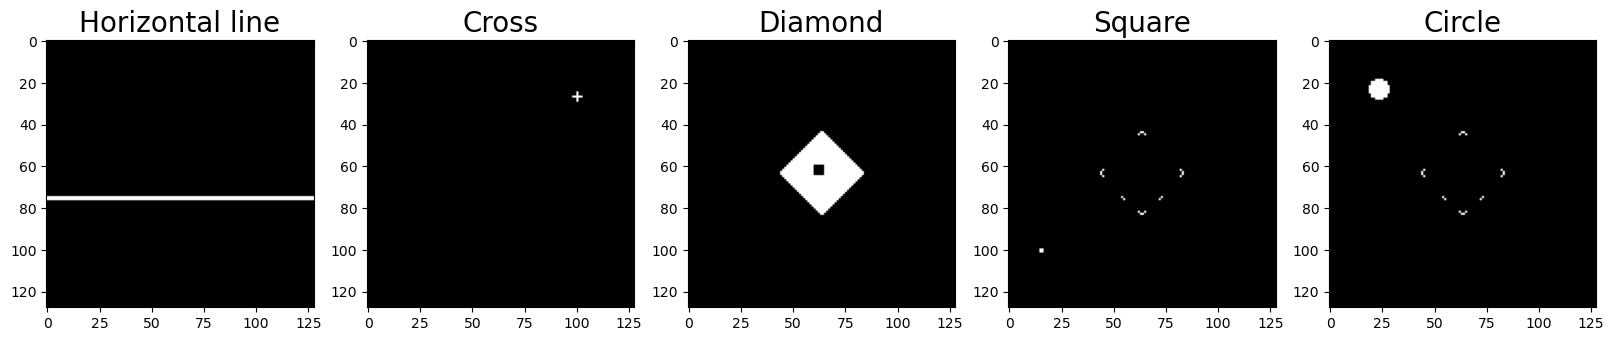

In [32]:
# Result display
plt.figure(figsize=(20,10))
plt.subplot(151)
plt.imshow(img_horzline,cmap='gray')
plt.title('Horizontal line',fontsize=20)
plt.subplot(152)
plt.imshow(img_cross,cmap='gray')
plt.title('Cross',fontsize=20)
plt.subplot(153)
plt.imshow(img_dmd,cmap='gray')
plt.title('Diamond',fontsize=20)
plt.subplot(154)
plt.imshow(img_sq,cmap='gray')
plt.title('Square',fontsize=20)
plt.subplot(155)
plt.imshow(img_circ,cmap='gray')
plt.title('Circle',fontsize=20)
plt.show()

In [26]:
# Checking if everything has been extracted

np.all(img == (img_horzline|img_cross|img_dmd|img_sq|img_circ))

True

**Congratulations!**

You've reached the end of this notebook.